Exploratory Data Analysis of the main features of the data and check the relationsships that hold between the variables and see which variables are important for our problem.

In [12]:
import pandas as pd
import mysql.connector

# MySQL-Verbindung herstellen
connection_params = {
    'host': 'localhost',
    'user': 'admin',
    'password': 'Criminal1234',
    'database': 'CriminalDataDB',
    'allow_local_infile': True
}

conn = mysql.connector.connect(**connection_params)
cursor = conn.cursor()

query = "SELECT * FROM Bevoelkerungsdichte bd JOIN Bevoelkerungsdaten bvd ON bd.Gemeindename = bvd.Gemeindename AND bd.Jahr = bvd.Jahr JOIN Einkommensdaten ed ON bd.BFS_NR = ed.BFS_NR AND bd.Gemeindename = ed.Gemeindename AND bd.Jahr = ed.Jahr JOIN Finanzvermoegen fv ON bd.BFS_NR = fv.BFS_NR AND bd.Gemeindename = fv.Gemeindename AND bd.Jahr = fv.Jahr JOIN Einbrueche en ON bd.BFS_NR = en.BFS_NR AND bd.Gemeindename = en.Gemeindename AND bd.Jahr = en.Jahr"
cursor.execute(query)

# Ergebnisse abrufen und in DataFrame laden
results = cursor.fetchall()
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(results, columns=columns)

# Verbindung schließen
cursor.close()
conn.close()

# Nehmen wir an, df ist dein DataFrame
# Hier sind die Spalten mit Duplikaten
duplicated_columns = ['Gemeindename', 'Jahr', 'BFS_NR']

# Verwende die Methode loc, um die Duplikate zu entfernen und nur die ersten Instanzen zu behalten
df_unique = df.loc[:, ~df.columns.duplicated()]

# Ergebnis anzeigen
print(df_unique)



      BFS_NR  Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131      Adliswil  2010                          2113.8   
1        131      Adliswil  2011                          2240.0   
2        131      Adliswil  2012                          2307.3   
3        131      Adliswil  2013                          2335.4   
4        131      Adliswil  2014                          2356.5   
...      ...           ...   ...                             ...   
2208      70  Wasterkingen  2019                           142.1   
2209     251     Weiningen  2017                           881.5   
2210     231          Zell  2018                           463.6   
2211     161      Zollikon  2022                          1714.5   
2212     160       Zumikon  2021                          1020.8   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   


In [13]:
directory = 'Cleaned_CSV_files'
current_directory = os.getcwd()

csv_path = os.path.join(current_directory, directory, 'EDA.csv')

# Create the directory if it doesn't exist
if not os.path.exists(os.path.join(current_directory, directory)):
    os.makedirs(os.path.join(current_directory, directory))

df_unique.to_csv(csv_path, index=False)
print(df_unique)

      BFS_NR  Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131      Adliswil  2010                          2113.8   
1        131      Adliswil  2011                          2240.0   
2        131      Adliswil  2012                          2307.3   
3        131      Adliswil  2013                          2335.4   
4        131      Adliswil  2014                          2356.5   
...      ...           ...   ...                             ...   
2208      70  Wasterkingen  2019                           142.1   
2209     251     Weiningen  2017                           881.5   
2210     231          Zell  2018                           463.6   
2211     161      Zollikon  2022                          1714.5   
2212     160       Zumikon  2021                          1020.8   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   


Check data types and related information, such as the quantity of records in each column, whether the data is null, the type of data

In [15]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   BFS_NR                                                  2213 non-null   int64  
 1   Gemeindename                                            2213 non-null   object 
 2   Jahr                                                    2213 non-null   int64  
 3   Einwohner_pro_Quadratkilometer                          2213 non-null   float64
 4   Einwohner 0-14 Jahre alt                                2213 non-null   int64  
 5   Einwohner 15-29 Jahre alt                               2213 non-null   int64  
 6   Einwohner 30-44 Jahre alt                               2213 non-null   int64  
 7   Einwohner 45-59 Jahre alt                               2213 non-null   int64  
 8   Einwohner 60-74 Jahre alt             

*Einwohner nach Alter*: Die Standardabweichung in diesen Spalten kann hoch sein, da die Altersverteilung von Gemeinde zu Gemeinde stark variieren kann. Einige Gemeinden könnten eine grosse Anzahl von Einwohnern in bestimmten Altersgruppen haben, während andere Gemeinden möglicherweise eine gleichmässigere Verteilung aufweisen. Weiters kann es in ländlichen Regionen vermehrt eher hohe Altersgruppen haben.

*durchschnittliches steuerbares Einkommen pro Einwohner, Finanzvermoegen_pro_Einwohner*: Diese Spalten könnten Ausreisser enthalten. Einige Gemeinden könnten aufgrund spezifischer wirtschaftlicher Bedingungen oder demografischer Merkmale ungewöhnlich hohe oder niedrige Einkommens- und Vermögenswerte aufweisen.

Es kann auch interessant sein, die Beziehung zwischen dem Alter der Einwohner und ihren Einkommens- oder Vermögensniveaus zu untersuchen. Ältere Einwohner haben oft höhere Einkommens- und Vermögenswerte aufgrund ihres langjährigen Berufslebens und ihrer Ersparnisse, während jüngere Einwohner möglicherweise niedrigere Einkommensniveaus aufweisen, aber auch das Potenzial für zukünftiges Einkommen haben.

In [14]:
df_unique.describe()

,BFS_NR,Jahr,Einwohner_pro_Quadratkilometer,Einwohner 0-14 Jahre alt,Einwohner 15-29 Jahre alt,Einwohner 30-44 Jahre alt,Einwohner 45-59 Jahre alt,Einwohner 60-74 Jahre alt,Einwohner 75-89 Jahre alt,Einwohner 90-104 Jahre alt,durchschnittliches_steuerbares_Einkommen_pro_Einwohner,Finanzvermoegen_pro_Einwohner,Einwohner,Einbruchdiebstahl_Total,Einschleichdiebstahl_Total,Einbruchdiebstahl_Versucht,Einschleichdiebstahl_Versucht,Einbruchdiebstahl_Vollendet,Einschleichdiebstahl_Vollendet
count,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000
mean,137.177135,2016.014008,1052.146905,5070.907366,6396.454135,10324.815635,7240.699503,4527.622684,2619.110258,376.337551,69797.163127,8146.208315,8569.277903,43.617262,10.909173,16.886127,0.654315,26.731134,10.254858
std,86.801515,3.741692,1226.716865,14177.155998,18506.317773,31040.214780,20139.768981,12344.181719,7451.196628,1151.778703,21513.504461,3788.946610,12693.910439,87.879404,20.502974,34.186975,1.508947,54.466129,19.411671
min,1.000000,2010.000000,62.000000,58.000000,43.000000,56.000000,77.000000,26.000000,18.000000,0.000000,9634.000000,2067.000000,306.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,2013.000000,258.900000,306.000000,316.000000,385.000000,497.000000,319.000000,123.000000,10.000000,59931.000000,5389.000000,1959.000000,4.000000,1.000000,1.000000,0.000000,2.000000,1.000000
50%,121.000000,2016.000000,577.800000,737.000000,765.000000,958.000000,1113.000000,745.000000,297.000000,25.000000,64779.000000,7365.000000,4661.000000,14.000000,4.000000,5.000000,0.000000,8.000000,3.000000
75%,218.000000,2019.000000,1243.500000,1568.000000,1630.000000,2083.000000,2306.000000,1594.000000,776.000000,77.000000,72022.000000,9891.000000,9447.000000,37.000000,10.000000,14.000000,1.000000,24.000000,10.000000
max,298.000000,2022.000000,4855.400000,59876.000000,75261.000000,127463.000000,83171.000000,48958.000000,30551.000000,4670.000000,581506.000000,45276.000000,115129.000000,783.000000,213.000000,311.000000,29.000000,503.000000,208.000000


Check if there are any empty values in the columns and how many unique values we can find within the table

In [16]:
df_unique.isnull().sum()    

BFS_NR                                                    0
Gemeindename                                              0
Jahr                                                      0
Einwohner_pro_Quadratkilometer                            0
Einwohner 0-14 Jahre alt                                  0
Einwohner 15-29 Jahre alt                                 0
Einwohner 30-44 Jahre alt                                 0
Einwohner 45-59 Jahre alt                                 0
Einwohner 60-74 Jahre alt                                 0
Einwohner 75-89 Jahre alt                                 0
Einwohner 90-104 Jahre alt                                0
durchschnittliches_steuerbares_Einkommen_pro_Einwohner    0
Finanzvermoegen_pro_Einwohner                             0
Einwohner                                                 0
Einbruchdiebstahl_Total                                   0
Einschleichdiebstahl_Total                                0
Einbruchdiebstahl_Versucht              

In [17]:
df_unique.nunique()

BFS_NR                                                     159
Gemeindename                                               159
Jahr                                                        13
Einwohner_pro_Quadratkilometer                            1871
Einwohner 0-14 Jahre alt                                  1274
Einwohner 15-29 Jahre alt                                 1278
Einwohner 30-44 Jahre alt                                 1405
Einwohner 45-59 Jahre alt                                 1426
Einwohner 60-74 Jahre alt                                 1252
Einwohner 75-89 Jahre alt                                  940
Einwohner 90-104 Jahre alt                                 250
durchschnittliches_steuerbares_Einkommen_pro_Einwohner    2000
Finanzvermoegen_pro_Einwohner                             1867
Einwohner                                                 1989
Einbruchdiebstahl_Total                                    272
Einschleichdiebstahl_Total                             


# Univariate Analysis
Boxplots for income and wealth data: Boxplots for average taxable income per resident and financial assets per resident to visualize the distribution and possible outliers in this data.

Time series plots for burglary: Time series plots for burglary and theft statistics over the years to identify trends over time.

Correlation matrix: Correlation matrix to visualize the correlations between different variables, such as the correlation between population size and burglary statistics or the correlation between income and population age.

Scatterplots: Scatterplots to examine the relationship between different variables, e.g. the correlation between population density and burglary rates or between income and financial assets.

Heatmaps: Heatmaps to visualize the spatial distribution of population density or burglary rates in different municipalities.


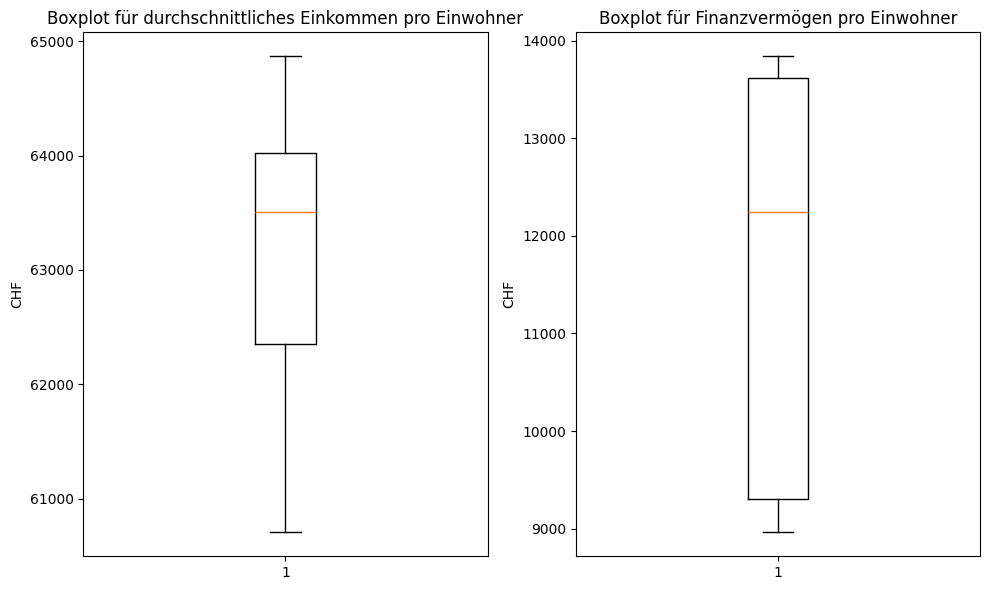

In [32]:

import matplotlib.pyplot as plt
df_2022_zurich = df_unique[(df_unique['Gemeindename'] == 'Zürich')]
# Daten filtern
income_data = df_2022_zurich['durchschnittliches_steuerbares_Einkommen_pro_Einwohner']
wealth_data = df_2022_zurich['Finanzvermoegen_pro_Einwohner']

# Boxplots erstellen
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)  # Erste Unterteilung für das Einkommens-Boxplot
plt.boxplot(income_data)
plt.title('Boxplot für durchschnittliches Einkommen pro Einwohner')
plt.ylabel('CHF')

plt.subplot(1, 2, 2)  # Zweite Unterteilung für das Vermögens-Boxplot
plt.boxplot(wealth_data)
plt.title('Boxplot für Finanzvermögen pro Einwohner')
plt.ylabel('CHF')

plt.tight_layout()
plt.show()


